In [15]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from torch import nn,optim,save
import torch

from datetime import datetime, timedelta

from sklearn.linear_model import LinearRegression

import pickle

In [16]:
# dati clinici:
clinical_raw = pd.read_csv("ClinicalData.csv").set_index("Case ID")

# RNA_seq normalizzati:
RNA_seq = pd.read_csv("RNAseq_norm.csv",index_col=0)

In [17]:
#filter low variance RNAs

RNA_low_variance_mask = RNA_seq.T.var() > RNA_seq.T.var().quantile(0.05)

RNA_filtered = RNA_seq[RNA_low_variance_mask]

print(RNA_filtered.shape)

(5004, 130)


In [18]:
# mi recupero il train-test-split che ho fatto sul dataset delle CT
with open('split_dictionary.pkl', 'rb') as f:
    split_dict = pickle.load(f)

train_set = [x[:-7] for x in split_dict["train"]]
val_set = [x[:-7] for x in split_dict["val"]]
test_set = [x[:-7] for x in split_dict["test"]]

all_set = train_set+val_set+test_set

In [19]:
#aggiungo al dataset dei dati clinici una colonna che indica il numero di giorni che il paziente è sopravvissuto dal giorno della CT

def cambia_date(x):
    return datetime.strptime(x,"%m/%d/%Y")

survival_list = list()
clinical_temp = clinical_raw.copy()

for sample in clinical_raw.iterrows():

    date_last = cambia_date(sample[1]["Date of Last Known Alive"])
    date_CT = cambia_date(sample[1]["CT Date"])
    days_CT_surgery = timedelta(days=sample[1]["Days between CT and surgery"])

    if date_last - date_CT > days_CT_surgery: # caso in cui hanno fatto surgery dopo della CT
        delta = date_last - date_CT - days_CT_surgery
    else: # caso in cui hanno fatto surgery prima della CT
        delta = date_last - date_CT + days_CT_surgery

    survival_list.append(delta.days)

clinical_temp["Days Survived"] = survival_list


In [20]:

from collections import Counter
print(Counter(clinical_temp['Pathological T stage']))
print(Counter(clinical_temp['Pathological N stage']))
print(Counter(clinical_temp['Pathological M stage']))

Counter({'Not Collected': 49, 'T2a': 47, 'T1a': 40, 'T1b': 31, 'T3': 21, 'T2b': 10, 'T4': 7, 'Tis': 6})
Counter({'N0': 129, 'Not Collected': 49, 'N2': 18, 'N1': 15})
Counter({'M0': 157, 'Not Collected': 49, 'M1b': 4, 'M1a': 1})


In [21]:
#mi recupero i dati clinici che mi interessano, fattorizzo

clinical_data = clinical_temp["Histology "]

clinical_dummy = pd.get_dummies(clinical_data)["Adenocarcinoma"]
clinical_dummy2 = pd.get_dummies(clinical_dummy)

clinical_adeno = clinical_dummy2.copy()

clinical_adeno.columns = ["no","yes"]


#clinical_adeno = clinical_dummy2["Adenocarcinoma"]

#print(pd.Series(x in clinical_adeno.index for x in RNA_seq.columns).all()) # tutti gli RNA hanno corrispondenti dati clinici

clinical_adeno

,no,yes
Case ID,,
AMC-001,0,1
AMC-002,0,1
AMC-003,0,1
AMC-004,0,1
AMC-005,0,1
...,...,...
R01-159,1,0
R01-160,0,1
R01-161,0,1


In [22]:
clinical_data

Case ID
AMC-001                         Adenocarcinoma
AMC-002                         Adenocarcinoma
AMC-003                         Adenocarcinoma
AMC-004                         Adenocarcinoma
AMC-005                         Adenocarcinoma
                          ...                 
R01-159                Squamous cell carcinoma
R01-160                         Adenocarcinoma
R01-161                         Adenocarcinoma
R01-162                         Adenocarcinoma
R01-163    NSCLC NOS (not otherwise specified)
Name: Histology , Length: 211, dtype: object

In [23]:
#divido in train/val/test rispettando lo split fatto sulle CT
# samples che non hanno CT sono messi nel validation set (perché altrimenti erano troppo pochi)

train_column = [x for x in train_set if x in RNA_seq.columns]
val_column = [x for x in val_set if x in RNA_seq.columns]
test_column = [x for x in test_set if x in RNA_seq.columns]

all_column = train_column + val_column + test_column

RNA_noCT = RNA_filtered.loc[:,~RNA_filtered.columns.isin(all_column)]

RNA_train = pd.concat([RNA_filtered.loc[:,train_column],RNA_noCT],axis=1).astype(float)
RNA_val = RNA_filtered.loc[:,val_column].astype(float)
RNA_test = RNA_filtered.loc[:,test_column].astype(float)

print(RNA_train.shape, RNA_val.shape, RNA_test.shape)


(5004, 100) (5004, 14) (5004, 16)


In [24]:
class RNAModel(torch.nn.Module):
  def __init__(self, input_dim):
    super(RNAModel, self).__init__()
    

    self.layers = nn.Sequential(nn.Linear(input_dim, input_dim//100, dtype=float), #5268
                           nn.ReLU(inplace=True),
                           nn.Linear(input_dim//100,2, dtype=float)
                           )

  def forward(self, x):

    # forward the input through the layers
    x = self.layers(x)

    return x

In [25]:
class my_dataset(torch.utils.data.Dataset):
    def __init__(self, split,RNA_train, RNA_val, RNA_test, clinical_adeno):
        self.split = split
        self.RNA_train = RNA_train
        self.RNA_val = RNA_val
        self.RNA_test = RNA_test
        self.y = clinical_adeno

    def __len__(self):
        if self.split == "train":
            return self.RNA_train.shape[1]
        elif self.split == "val":
            return self.RNA_val.shape[1]
        elif self.split == "test":
            return self.RNA_test.shape[1]
    def __getitem__(self,idx):
        
        if self.split == "train":
            x = torch.from_numpy(self.RNA_train[RNA_train.columns[idx]].apply(lambda x: x + x*np.random.uniform(-0.001,0.001)).astype(float).to_numpy())
            y = torch.from_numpy(self.y.loc[RNA_train.columns[idx],:].astype(float).to_numpy())
            return x,y
        elif self.split == "val":
            x = torch.from_numpy(self.RNA_val[RNA_val.columns[idx]].to_numpy())
            y = torch.from_numpy(self.y.loc[RNA_val.columns[idx],:].astype(float).to_numpy())
            return x,y

        elif self.split == "test":
            x = torch.from_numpy(self.RNA_test[RNA_test.columns[idx]].to_numpy())
            y = torch.from_numpy(self.y.loc[RNA_test.columns[idx],:].astype(float).to_numpy())
            return x,y


In [26]:
dataset = my_dataset("train", RNA_train, RNA_val, RNA_test, clinical_adeno)

dataloader = torch.utils.data.DataLoader(dataset, batch_size = 10, shuffle=True)

In [27]:

classes = Counter(dataset.y.loc[RNA_train.columns,"no"])

w_adeno = classes[1]/classes[0]
w_other = classes[0]/classes[1]

print(w_adeno, w_other)

0.2987012987012987 3.347826086956522


In [28]:
# creo modello, loss function, optimizer

my_model = RNAModel(input_dim=RNA_filtered.shape[0])

#randomize initial weights and bias
for name, layer in my_model.named_children():
    for c_name, c_layer in layer.named_children():
        if hasattr(c_layer, "weight") == True:
            nn.init.xavier_uniform_(c_layer.weight)
        if hasattr(c_layer, "bias") == True:
            c_layer.bias.data.fill_(0.)

my_loss = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([w_other, w_adeno]))

my_optim = optim.Adam(my_model.parameters(), lr=1e-5)

my_model

RNAModel(
  (layers): Sequential(
    (0): Linear(in_features=5004, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [29]:
# per ogni epoca:
#     per ogni sample nel training set:
#         azzera gradienti dell'optimizer
#         metti un po' di noise nei dati
#         dividi dati del sample in input e target
#         ottieni output dal modello
#         se sample è vivo e output > target:
#             se output > 5 anni:
#                 calcola loss tra output e [5 anni]
#             else:
#                 non calcolare la loss, passa al prossimo sample senza fare back-propagation
#         else:
#             calcola loss tra output e target
#         back-propagation
#         optimizer.step()
#     ripeti sul validation set, ma senza fare back-propagation
#     salva il modello

train_losses = []
val_losses = []


for epoch in range(500):

    print(f"\nstarting epoch {epoch}")

    epoch_train_loss = []

    my_model.train()

    dataset.split = "train"

    for batch_idx, (inputs, targets) in enumerate(dataloader):

        #x_train = inputs.reshape([inputs.shape[0], 1, inputs.shape[1]])
        #y_train = targets.reshape([targets.shape[0], 1, targets.shape[1]])
        
        my_optim.zero_grad()

        #sample = RNA_train[s_name]
        
        output = my_model(inputs)

        sample_loss = my_loss(output, targets)
    
        sample_loss.backward()
        my_optim.step()

        epoch_train_loss.append(sample_loss.item())

    mean_train_loss = pd.Series(epoch_train_loss).mean()

    print(f"train loss: {mean_train_loss}")
    train_losses.append(mean_train_loss)

    epoch_val_loss = []

    my_model.eval()

    dataset.split = "val"

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        
        x_val = inputs.reshape([inputs.shape[0], 1, inputs.shape[1]])
        
        output = my_model(inputs)

        sample_loss = my_loss(output, targets)
    
        epoch_val_loss.append(sample_loss.item())

    mean_val_loss = pd.Series(epoch_val_loss).mean()

    print(f"val loss: {mean_val_loss}")

    val_losses.append(mean_val_loss)

    if epoch == 0 or mean_val_loss < minor_val_loss:

        minor_val_loss = mean_val_loss

        checkpoint = { 
            'epoch': epoch,
            'model': my_model.state_dict(),
            'optimizer': my_optim.state_dict()}
            # "scheduler": my_scheduler}

        save(checkpoint,f"RNA_class_epochs/{epoch}.pth")

print("finished!")   


starting epoch 0


train loss: 2.6150178682679104
val loss: 1.4922724342227978

starting epoch 1
train loss: 1.1024987576147471
val loss: 1.0734032124824688

starting epoch 2
train loss: 0.8351754826276071
val loss: 1.0177336802669008

starting epoch 3
train loss: 0.781864419780513
val loss: 1.1736600565104838

starting epoch 4
train loss: 0.7274375426894036
val loss: 1.0565256680793749

starting epoch 5
train loss: 0.7365928132037445
val loss: 0.8972926696286272

starting epoch 6
train loss: 0.7082170925837247
val loss: 0.9438386731421968

starting epoch 7
train loss: 0.7135022941388028
val loss: 0.9698202330156198

starting epoch 8
train loss: 0.707721611244168
val loss: 1.0053351050528023

starting epoch 9
train loss: 0.7117662272121328
val loss: 1.091451714386353

starting epoch 10
train loss: 0.6773523004431039
val loss: 1.11558015620161

starting epoch 11
train loss: 0.6775445144265407
val loss: 1.211276006812249

starting epoch 12
train loss: 0.6760167519539012
val loss: 0.8221737250814849

starti

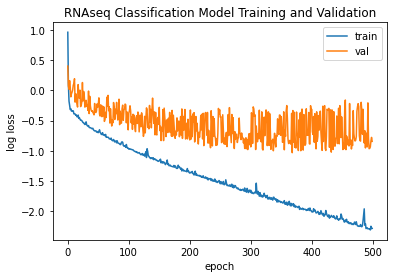

In [30]:
# plot di epoch vs loss su train(blu) e val(arancio)

plt.plot(np.log(train_losses))
plt.plot(np.log(val_losses))
plt.legend(["train", "val"])
plt.title("RNAseq Classification Model Training and Validation")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

In [31]:
val_series = pd.Series(val_losses, dtype=float)

print(f"epoch with lowest val loss: {val_series.argmin()}")
print(f"train loss of said epoch: {train_losses[val_series.argmin()]}")
print(f"val loss of said epoch: {val_losses[val_series.argmin()]}")

epoch with lowest val loss: 368
train loss of said epoch: 0.1516905190035435
val loss of said epoch: 0.35582235413091406


In [33]:
best_checkpoint = torch.load("RNA_class_epochs/368.pth")

best_model = RNAModel(input_dim=RNA_filtered.shape[0])
best_model.load_state_dict(best_checkpoint["model"])
best_model.eval()

RNAModel(
  (layers): Sequential(
    (0): Linear(in_features=5004, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [34]:
from captum.attr import IntegratedGradients


ig = IntegratedGradients(best_model)

In [64]:
expected = []
predicted = []
attributes = []

dataset.split= "val"
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle=True)


for batch_idx, (inputs, targets) in enumerate(dataloader):
    
    x_val = inputs.reshape([inputs.shape[0], 1, inputs.shape[1]])
    
    attributes.append(ig.attribute(inputs, target=0).numpy())
    output = my_model(inputs)

    expected.append(targets[0][0].item())
    new_output = output.argmin()
    predicted.append(new_output.item())



In [78]:
np_attributes = np.array(attributes)
print(np_attributes.shape)


(14, 1, 5004)


[[-0.0250927   0.00374682  0.22517412 ...  0.0524708  -0.00672203
   0.08960086]]
Index(['A2M', 'AAGAB', 'AAK1', 'AAMP', 'AARS', 'AARS2', 'AASDHPPT', 'AASS',
       'AATF', 'ABCA1',
       ...
       'ZNHIT1', 'ZNHIT6', 'ZNRF2', 'ZRANB1', 'ZSWIM6', 'ZXDC', 'ZYG11B',
       'ZYX', 'ZZEF1', 'ZZZ3'],
      dtype='object', length=5004)


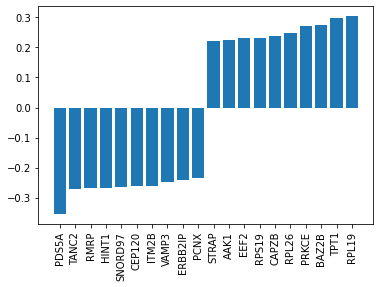

In [107]:
attr_mean = np_attributes.mean(axis=0)
print(attr_mean)

print(RNA_val.index)

attr_series = pd.Series(attr_mean.ravel(),index = RNA_val.index).sort_values()

best_attrs = attr_series[:10]
worst_attrs = attr_series[-10:]

attrs = pd.concat([best_attrs, worst_attrs])

plt.bar(attrs.index, attrs)
plt.xticks(rotation=90)
plt.show()

In [38]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix
mcc = matthews_corrcoef(expected, predicted)

conf_matrix = confusion_matrix(expected,predicted)
print(conf_matrix)

print(mcc)


[[8 1]
 [1 4]]
0.6888888888888889
